In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt

# positional encoding
- 트랜스포머는 입력 받을 때 문장 전체를 받는다.
- 그러므로 모델에게 따로 어순을 알려줘야 하므로 단어의 임베딩 벡터에 위치 정보를 가진 positional encoding 값을 더해서 입력으로 삼는다.
- pos: 입력 문장에서 임베딩 벡터의 위치 
- i: 입력 문장에서 임베딩 벡터의 차원 인덱스
- 차원 인덱스가 짝수인 경우 사인 함수 사용
- 차원 인덱스가 홀수인 경우 코사인 함수 사용 
- d_model: 모든 층의 출력 차원


In [2]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model): # 위치와 모델의 차원에 맞는 포지셔널 인코딩 생성 
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model): # 위치와 차원에 대한 각도 계산 
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs): # 입력 텐서에 포지셔널 인코딩 더함
        if isinstance(inputs, tf.SparseTensor):
            inputs = tf.sparse.to_dense(inputs)
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]


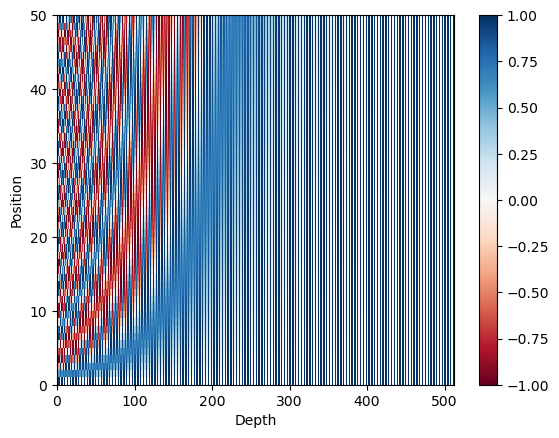

In [3]:
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

# attention
- 쿼리에 대해서 모든 키와의 유사도를 구함
- 구한 유사도를 키와 맵핑되어있는 각각의 값에 반영
- 유사도 반영된 값을 가중합 하면 어텐션 값이 됨
- query
- key
- value
- qkv 모두 단어(정보를 함축한) 벡터다.
- 트랜스포머의 여러 연산을 거친 후의 단어 벡터

## 어텐션 종류 
1. 인코더 셀프 어텐션: 인코더의 입력이로 들어간 문장 내 단어들이 서로 유사도를 구함 
2. 디코더 셀프 어텐션: 단어를 1개씩 생성하는 디코더가 이미 생성된 앞 단어들과 유사도를 구함 
3. 인코더-디코더 어텐션 : 디코더가 잘 예측하기 위해 인코더에 입력된 단어들과 유사도를 구함
- 1,2번이 셀프어텐션으로 문장 내의 단어들이 서로 유사도를 구하는 경우를 의미한다. 

# scaled-dot-product-attention
- attention(Q,K,V)=softmax(QK^t/sqrt(d))v
1. q,k,v는 단어 벡터를 행으로 하는 문장 행렬
2. 벡터의 내적은 벡터의 유사도를 의미함
3. d를 분모로 하는 것은 값의 크기를 조절하는 스케일링을 위함이다. 

![nn](qkv.jpg)

In [4]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  matmul_qk = tf.matmul(query, key, transpose_b=True) # 쿼리와 키의 내적을 계산하여 어텐션 가중치 생성 

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32) 
  logits = matmul_qk / tf.math.sqrt(depth) # 가중치를 sqrt(depth)로 나누어 

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9) # 마스크를 적용하여 패딩 위치에 영향을 주지 않도록 

  # softmax적용 # 정규화된 값을 softmax 함수를 통해 확률 분포로 변환하여 쿼리에 대해 키와의 관련도 계산 
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 어텐션 가중치를 값에 곱해 최종 어텐션 계산 
  output = tf.matmul(attention_weights, value)
  return output

# multi-head-attention
- num_heads: 병렬적으로 몇 개의 어텐션 연산을 수행할지 결정하는 하이퍼파라미터
- d_model: 임베딩 벡터의 차원 - 입력 초기 문장 행렬의 열 크기
- 문장 행렬을 num_heads만큼 쪼개서 어텐션 수행하고 , 이렇게 얻은 num_heads 개수만큼 어텐션 값 행렬을 다시 concatenate 하여 열의 크기가 d_model만큼 된다. 

In [5]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
      # 모델의 차원과 헤드 수를 초기화
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0
        # 헤드의 깊이 계산 
    self.depth = d_model // self.num_heads
    # 쿼리 키 값 정의 
    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)
    # dense 층 정의 
    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
      # 입력을 여러 헤드로 나눔 
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

# 각 헤드에 대해 어텐션을 계산한 후, 다시 결합하여 최종 출력 생성 
  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs

# 마스킹 
- 특정 값을 가려서 실제 연산에 방해가 되지 않도록 하는 기법
1. 패딩 마스킹
2. 룩 어헤드 마스킹 

## 패딩 마스킹 
- 문장 길이가 다를 때 모든 문장 길이를 동일하게 해주는 과정에서 숫자 0을 채워서 문장의 길이를 맞춰주는 방법
- 0이 실제로 의미가 없기 때문에 0의 위치를 체크한다. 

In [6]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [7]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))
# 0인 위치에1 아닌 곳에 0

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


## 룩어헤드 마스킹 
- 트랜스포머인 경우 전체 문장이 문장 행렬로 입력하기 때문에 위치와 상관없이 모든 단어를 참고하여 다음 단어 예측 가능
- 이전 단어들로부터 다음 단어를 예측해야 하기 때문에 자신보다 다음에 나올 단어를 참고하지 않도록 다음 단어를 가림
- query 뒤에 나오는 key 단어들에 대해 마스킹 한다. 

In [8]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

In [9]:
print(create_look_ahead_mask(tf.constant([[1, 2, 3, 4, 5]])))
# 뒷 단어들을 색칠, 1로 표시

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 0. 1. 1.]
   [0. 0. 0. 0. 1.]
   [0. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


In [10]:
x=tf.constant([[1, 2, 3, 4, 5]])


In [11]:
tf.shape(x)[1]

<tf.Tensor: shape=(), dtype=int32, numpy=5>

# 인코더
- 셀프 어텐션 => 멀티 헤드 어텐션으로 병렬적으로 이루어진다. 
- 피드 포워드 신경망

## 두개의 서브 층을 가지는 하나읜 인코더층을 구현하는 함수 
- 첫 번째 서브층과 두 번째 서브 층을 구현하고 있음 

In [12]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재함
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs") # 배치, 시퀀스길이, d_model 형태의 텐서 

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization 적용하여 과적합 방지
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention) # 첫번째 dense units 크기 출력
  outputs = tf.keras.layers.Dense(units=d_model)(outputs) # d_model 크기로 맵핑 

  # 완전연결층의 결과는 Dropout과 LayerNormalization 한 번 더 
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

![nn](encoder_layer.jpg)

## 인코더 층을 쌓아 인코더 만들기
- 사용자가 원하는 만큼 인코더 층을 쌓음으로써 트랜스포머의 인코더가 완성된다.
- layer normalization이라는 테크닉 활용 

In [13]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs") # 시퀀스의 각 토큰에 해당하는 인덱스 입력 

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask") 

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs) # 입력을 d_model 차원의 임베딩으로 변환 
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32)) # sqrt(d_model)로 스케일링하여 크기 조정 

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i), # 이전 레이어의 출력을 받아 연산 수행 
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

# 디코더
- 디코더는 인코더에 비해 세 개의 서브 층으로 구성된다.
- 셀프 어텐션- 인코더 디코더 어텐션- 피드 포워드 신경망
- 인코더 디코더 어텐션은 qeury가 디코더인 반면 key와 value가 인코더의 벡터이다.
- 인코더가 입력 문장으로부터 정보를 디코더에 전달하는 과정

![nn](encoder_decoder.jpg)

## 디코더 층

In [14]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs") # 배치,시퀀스,d_model 형태의 텐서의 디코더 입력
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs") # 인코더 출력 
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask") # 시퀀스 미래 정보 가릴 마스크 
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask') # 패딩 토큰 가리기 마스크 

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    # 미래 못보도록 
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization 적용 
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization 적용 
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
    # 인코더 디코더 어텐션 결과 처리 
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2) 
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

## 디코더 층 쌓기

In [15]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers): # 쌓기 
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)


# 모델 정의 및 학습

In [16]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

# 내 데이터 전처리

In [20]:
# 여기서 우리 법률+심리 상담 대화 데이터셋 넣어서 하면 될듯 
import pandas as pd 
result_df=pd.read_csv('mind_conversation.csv')

In [22]:
result_df=result_df.iloc[:100]

In [23]:
questions = []
for sentence in result_df['context']:
    # 구두점에 대해서 띄어쓰기
    # ex) 12시 땡! -> 12시 땡 !
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    questions.append(sentence)


In [24]:
answers = []
for sentence in result_df['response']:
    # 구두점에 대해서 띄어쓰기
    # ex) 12시 땡! -> 12시 땡 !
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    answers.append(sentence)


In [25]:
# 서브워드텍스트인코더를 사용하여 질문, 답변 데이터로부터 단어 집합(Vocabulary) 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2**13)


In [26]:
# 디코더의 문장 생성 과정에서 사용할 시작 토큰과 종료 토큰에 대한 정수 부여.
# 이미 생성된 단어장의 번호와 겹치지 않도록 단어장의 크기보다 1 큰 수로 번호 부여
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# 시작 토큰과 종료 토큰을 고려하여 단어 집합의 크기를 + 2
# 두개의 토큰 추가했기 때문에 단어장 크기도 +2
VOCAB_SIZE = tokenizer.vocab_size + 2


In [27]:
print('시작 토큰 번호 :',START_TOKEN)
print('종료 토큰 번호 :',END_TOKEN)
print('단어 집합의 크기 :',VOCAB_SIZE)


시작 토큰 번호 : [1225]
종료 토큰 번호 : [1226]
단어 집합의 크기 : 1227


In [28]:
# 최대 길이를 40으로 정의
MAX_LENGTH = 40

# 토큰화 / 정수 인코딩 / 시작 토큰과 종료 토큰 추가 / 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []

  for (sentence1, sentence2) in zip(inputs, outputs):
    # encode(토큰화 + 정수 인코딩), 시작 토큰과 종료 토큰 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    tokenized_inputs.append(sentence1)
    tokenized_outputs.append(sentence2)

  # 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

  return tokenized_inputs, tokenized_outputs


In [29]:
questions2, answers2 = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions2)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers2)))

단어장의 크기 : 1227
필터링 후의 질문 샘플 개수: 100
필터링 후의 답변 샘플 개수: 100


In [30]:
# 텐서플로우 dataset을 이용하여 셔플(shuffle)을 수행하되, 배치 크기로 데이터를 묶는다.
# 또한 이 과정에서 교사 강요(teacher forcing)을 사용하기 위해서 디코더의 입력과 실제값 시퀀스를 구성한다.
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더의 실제값 시퀀스에서는 시작 토큰을 제거해야 한다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions2,
        'dec_inputs': answers2[:, :-1] # 디코더의 입력. 마지막 패딩 토큰이 제거된다.
    },
    {
        'outputs': answers2[:, 1:]  # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거된다.
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)


## 학습 

In [31]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ inputs (InputLayer)           │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dec_inputs (InputLayer)       │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ enc_padding_mask (Lambda)     │ (None, 1, 1, None)        │               0 │ inputs[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ encoder (Functional)          │ (None, None, 256)         │       1,368,320 │ inputs[0][0],              │
│                               │                           │                 │ enc_padding_mask[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ look_ahead_mask (Lambda)      │ (None, 1, None, None)     │               0 │ dec_inputs[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dec_padding_mask (Lambda)     │ (None, 1, 1, None)        │               0 │ inputs[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ decoder (Functional)          │ (None, None, 256)         │       1,895,680 │ dec_inputs[0][0],          │
│                               │                           │                 │ encoder[0][0],             │
│                               │                           │                 │ look_ahead_mask[0][0],     │
│                               │                           │                 │ dec_padding_mask[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ outputs (Dense)               │ (None, None, 1227)        │         315,339 │ decoder[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 3,579,339 (13.65 MB)

 Trainable params: 3,579,339 (13.65 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred) 

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32) # 패딩 부분을 마스킹 하기 
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss) #모든 샘플의 손실 평균내기 

In [33]:
import tensorflow as tf

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000): # 학습률 천천히 증가하도록 조정하는 단계 수 
        super(CustomSchedule, self).__init__()
        
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, tf.float32)  # step 값을 float32로 변환
        arg1 = tf.math.rsqrt(step) # 학습단계가 증가할수록 학습률이 감소하도록 함 
        arg2 = step * (self.warmup_steps**-1.5)

        # 초기에는 증가하다가 이후에 감소 
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


Text(0.5, 0, 'Train Step')

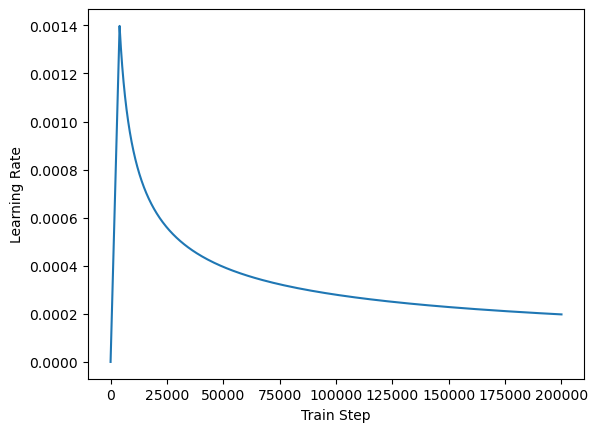

In [34]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [35]:
learning_rate = CustomSchedule(D_MODEL)
# adam 사용 
optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
# 
def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred) # 정수 레이블로 정확도 계산 

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

### 에포크 높이면 좋을듯

In [36]:
EPOCHS = 10 # 에포크 조금 더 높이면 좋을듯!!!! 
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 46s 710ms/step - accuracy: 4.7543e-04 - loss: 2.1115
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 711ms/step - accuracy: 0.0000e+00 - loss: 2.1335
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.0000e+00 - loss: 2.1192
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 692ms/step - accuracy: 1.7094e-04 - loss: 2.1283
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 679ms/step - accuracy: 0.0000e+00 - loss: 2.1228
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 646ms/step - accuracy: 1.7094e-04 - loss: 2.1242
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 626ms/step - accuracy: 0.0000e+00 - loss: 2.1351
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 685ms/step - accuracy: 4.7543e-04 - loss: 2.1205
Epoch 9/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 680ms/step - accuracy: 3.0449e-04 - loss: 2.1272
Epoch 10/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 662ms/step - accuracy: 0.0000e+00 - loss: 2.0905


In [47]:
# ! pip uninstall h5py
# ! pip install h5py
! pip uninstall pandas

^C


In [44]:
from transformers import TFAutoModel, AutoTokenizer

# 모델을 저장할 디렉토리 지정
save_directory = "./my_transformer_model"

# .keras 확장자를 사용한 저장
model.save(save_directory + ".keras")

# 또는 .h5 확장자를 사용한 저장
model.save(save_directory + ".h5")


ImportError: h5py must be installed in order to save a model.

In [38]:
def preprocess_sentence(sentence):
  # 단어와 구두점 사이에 공백 추가.
  # ex) 12시 땡! -> 12시 땡 !
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = sentence.strip()
  return sentence

In [39]:
def evaluate(sentence):
  # 입력 문장에 대한 전처리
  sentence = preprocess_sentence(sentence)

  # 입력 문장에 시작 토큰과 종료 토큰을 추가
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  output = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 예측 시작
  for i in range(MAX_LENGTH):
    predictions = model(inputs=[sentence, output], training=False)

    # 현재 시점의 예측 단어를 받아온다.
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 시점의 예측 단어가 종료 토큰이라면 예측을 중단
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 현재 시점의 예측 단어를 output(출력)에 연결한다.
    # output은 for문의 다음 루프에서 디코더의 입력이 된다.
    output = tf.concat([output, predicted_id], axis=-1)

  # 단어 예측이 모두 끝났다면 output을 리턴.
  return tf.squeeze(output, axis=0)


In [40]:
def predict(sentence):
  prediction = evaluate(sentence)

  # prediction == 디코더가 리턴한 챗봇의 대답에 해당하는 정수 시퀀스
  # tokenizer.decode()를 통해 정수 시퀀스를 문자열로 디코딩.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('Input: {}'.format(sentence))
  print('Output: {}'.format(predicted_sentence))

  return predicted_sentence


In [41]:
output = predict('나 너무 외로운거 같아')

Input: 나 너무 외로운거 같아
Output: ������������������������때마다 �때마다 시선을 �


In [ ]:
# 여기까지

# 데이터 전처리 
- 정규 표현식을 사용하여 구두점을 제거
- 단어 토크나이징 하는 일에 방해가 되지 않도록 정제하는 것을 목표로 함 

In [39]:
# 사용할 샘플의 최대 개수
MAX_SAMPLES = 50000
print(MAX_SAMPLES)

50000


In [29]:
path_to_zip = tf.keras.utils.get_file(
    'cornell_movie_dialogs.zip',
    origin='http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip',
    extract=True)

path_to_dataset = os.path.join(
    os.path.dirname(path_to_zip), "cornell movie-dialogs corpus")

path_to_movie_lines = os.path.join(path_to_dataset, 'movie_lines.txt')
path_to_movie_conversations = os.path.join(path_to_dataset,'movie_conversations.txt')

9916637/9916637 ━━━━━━━━━━━━━━━━━━━━ 14s 1us/step


In [44]:
# 전처리 함수
def preprocess_sentence(sentence):
  sentence = sentence.lower().strip()

  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "I am a student." => "I am a student ."와 같이
  # student와 온점 사이에 거리를 만듭니다.
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

  # (a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
  sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
  sentence = sentence.strip()
  return sentence

In [48]:
# 질문과 답변의 쌍인 데이터셋을 구성하기 위한 데이터 로드 함수
def load_conversations():
  id2line = {}
  with open(path_to_movie_lines, errors='ignore') as file:
    lines = file.readlines()
  for line in lines:
    parts = line.replace('\n', '').split(' +++$+++ ')
    id2line[parts[0]] = parts[4]

  inputs, outputs = [], []
  with open(path_to_movie_conversations, 'r') as file:
    lines = file.readlines()

  for line in lines:
    parts = line.replace('\n', '').split(' +++$+++ ')
    conversation = [line[1:-1] for line in parts[3][1:-1].split(', ')]

    for i in range(len(conversation) - 1):
      # 전처리 함수를 질문에 해당되는 inputs와 답변에 해당되는 outputs에 적용.
      inputs.append(preprocess_sentence(id2line[conversation[i]]))
      outputs.append(preprocess_sentence(id2line[conversation[i + 1]]))

      if len(inputs) >= MAX_SAMPLES:
        return inputs, outputs
  return inputs, outputs

In [49]:
questions, answers = load_conversations()
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 50000
전체 샘플 수 : 50000


In [36]:
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[20]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[20]))

전처리 후의 22번째 질문 샘플: i really , really , really wanna go , but i can t . not unless my sister goes .
전처리 후의 22번째 답변 샘플: i m workin on it . but she doesn t seem to be goin for him .


# 병렬 데이터 전처리
- SubwordTextEncoder를 토크나이저로 사용한다.
- 단어보다 더 작은 단위인 Subword를 기준으로 토크나이징하고, 각 토큰을 고유한 정수로 인코딩함
- 각 문장을 토큰화하고 문장과 시작의 끝을 나타내는 start_token 및 end_token 추가
- 최대 길이 40을 넘는 것들 필터링
- 최대 길이보다 짧은 문장들은 40에 맞도록 패딩 

## 단어장 만들기

In [52]:
import tensorflow_datasets as tfds
# 질문과 답변 데이터셋에 대해서 Vocabulary 생성. (Tensorflow 2.3.0 이상) (클라우드는 2.4 입니다)
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)


- 시작 토큰과 종료 토큰에 대해서도 단어장에 추가하여 정수 부여
- 각가 단어장의 크기와 그보다 1이 큰 수를 번호로 부여

In [54]:
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8331]
END_TOKEN의 번호 : [8332]


In [56]:
# 두개의 토큰 추가해줬기 때문에 단어장의 크기도 +2
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8333


- tokenizer.encode()로 각 단어를 정수로 변환
- tokenizer.decode()를 통해 정수 시퀀스를 단어 시퀀스로 변환

In [57]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [60, 8, 37, 8172, 49]
정수 인코딩 후의 21번째 답변 샘플: [7824, 1223, 19, 61, 2, 4, 336, 10, 1595, 14, 1104, 698, 3263, 263, 16, 71, 14, 107, 2133, 900, 3, 59, 4, 23, 355, 204, 60, 8, 37, 885, 2289, 8107, 344, 1001, 5179, 4214, 342, 1]


In [58]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 40
print(MAX_LENGTH)

40


In [59]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs

In [60]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8333
필터링 후의 질문 샘플 개수: 44095
필터링 후의 답변 샘플 개수: 44095


In [61]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)